In [ ]:
# Packages used
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as sp
import os
import pickle
import time
np.random.seed(100)

In [2]:
def load_dataset(name):
    X, y = [], []
    with open("{}".format(name), 'r') as f:
        for line in f.readlines():
            splitted = line.split(",")
            X.append(splitted[:-1])
            y.append(splitted[-1])
    X, y = np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)
    return X, y

In [3]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

In [4]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

In [5]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D

In [6]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0] # number of the training inputs
    n_test = Xte.shape[0] # number of the test inputs

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    # Compute all the distances from test input and training input
    dist = allDistances(Xte, Xtr)
    
    # For each test point, the predicted class will be 
    # the sign of the average label of the k nearest points
    for idx in range(n_test):
        # All the distances for the current test point
        idx_dist = dist[idx]
        # Sorting the indices of the distances
        order_idx_dist = np.argsort(idx_dist)
        
        # Getting the k lowest distence's indices
        k_idx_dist = order_idx_dist[:k]
        # Computing the mean of the output values of the corresponding training points
        Ypred[idx] = np.mean(Ytr[k_idx_dist])
    return Ypred


In [7]:
def separatingFkNN(Xtr, Ytr, k, Xte):
    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xte)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 500)
    yi = np.linspace(y.min(), y.max(), 500)
    zi = griddata((x, y), Ypred, (xi[None, :], yi[:, None]), method='linear')

    plt.subplots()
    CS = plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    #plt.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)
    plt.scatter(x[Ytr==1], y[Ytr==1], c="#C59434", marker='o', s=50, zorder=10, alpha=0.8)
    plt.scatter(x[Ytr==-1], y[Ytr==-1], c="#092C48", marker='o', s=50, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())
    #msg = 'Separating function, k='+str(k);
    #plt.title(msg)

In [8]:
def calcErrorKNN(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

In [9]:
def KFoldCVkNN(Xtr, Ytr, num_folds, hyperparam_list):
    """Run K-Fold CV for the kNN model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - hyperparam_list : List[int]
         the values of k (for k-NN) to try.
         
    Returns:
    --------
     - best_k : int
         The value of k (in k_list) which obtains the best average validation error
     - best_k_idx : int
         The index of the best_k element in k_list
     - tr_err_mean : np.array
         A 1D array of the same length as k_list, with the average training error for each tested k.
     - tr_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation 
         of the training error for each tested k.
     - val_err_mean : np.array
         A 1D array of the same length as k_list, with the average validation error for each tested k.
     - val_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation
         of the validation error for each tested k.
    """
    rnd_state = np.random.RandomState()
    # Ensures that k_list is a numpy array
    hyperparam_list = np.array(hyperparam_list)
    num_k = len(hyperparam_list)

    n_tot = Xtr.shape[0]

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_k, num_folds))
    val_errors = np.zeros((num_k, num_folds))

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rnd_state.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        # Split training set in training part and validation part
        # Hint: you can use boolean mask as index vector to split Xtr and Ytr
        x_train = Xtr[val_mask==False]
        y_train = Ytr[val_mask==False]
        x_val = Xtr[val_mask==True]
        y_val = Ytr[val_mask==True]
        
        for k_idx, current_k in enumerate(hyperparam_list):
            # Compute the training error of the kNN classifier for the given value of k
            tr_errors[k_idx, fold_idx] = calcErrorKNN(kNNClassify(x_train, y_train, current_k, x_train), y_train)
            val_errors[k_idx, fold_idx] = calcErrorKNN(kNNClassify(x_train, y_train, current_k, x_val), y_val)
            
    # Calculate error statistics along the repetitions:
    # 1) mean training error, training error standard deviation
    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)
    # 2) mean validation error, validation error standard deviation
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    # 3) best k (k which minimize mean validation error) and index of best k in hyperparam_list
    best_k = hyperparam_list[np.argmin(val_err_mean)]
    best_k_idx = np.argmin(val_err_mean)
    
    return best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std

RLS 

In [10]:
def regularizedLSTrain(Xtr, Ytr, lam):
        n = Xtr.shape[0]
        I = np.eye(Xtr.shape[1])
        
        # Step 1: Build the left-hand side matrix A and the right-hand side matrix b
        A = Xtr.T @ Xtr + lam * n * I
        b = Xtr.T @ Ytr
        
        # Step 2: Compute the Cholesky decomposition of A
        L = np.linalg.cholesky(A)
        
        # Step 3: Solve the two triangular systems
        # First solve L @ y = b for y
        y = sp.solve_triangular(L, b, lower=True)
        
        # Then solve L.T @ w = y for w
        w = sp.solve_triangular(L.T, y, lower=False)
        
        return w

In [11]:
def regularizedLSTest(w, Xte):
    # Insert your code here
    Ypred = Xte @ w
    return Ypred

In [12]:
def calcErrorRLS(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

In [13]:
def KFoldCVRLS(Xtr, Ytr, KF, regpar_list):
    if KF <= 1:
        raise Exception("Please supply a number of fold > 1")

    # Ensures that regpar_list is a numpy array
    regpar_list = np.array(regpar_list)
    num_regpar = regpar_list.size

    n_tot = Xtr.shape[0]
    n_val = int(n_tot // KF)

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_regpar, KF))
    val_errors = np.zeros((num_regpar, KF))

    for fold in range(KF):
        # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
        rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
        split_idx = np.array_split(rand_idx, KF)
        for idx, regpar in enumerate(regpar_list):
            # Set the indices in boolean mask for all validation samples to `True`
            val_mask = np.zeros(n_tot, dtype=bool)
            val_mask[split_idx[fold]] = True

            # Use the boolean mask to split X, Y in training and validation part

            X = Xtr[val_mask==False]   # training input 
            Y = Ytr[val_mask==False]  # training output 
            X_val = Xtr[val_mask==True]  # validation input
            Y_val = Ytr[val_mask==True]  # validation output
            
            # Train a RLS model for a single fold, and the given value of `regpar`
            currW = regularizedLSTrain(X, Y, regpar)
            
            # Compute the training error of the RLS regression for the given value of regpar
            YpredTR = regularizedLSTest(currW, X)
            tr_errors[idx, fold] = calcErrorRLS(YpredTR, Y)

            # Compute the validation error of the RLS regression for the given value of regpar
            YpredVAL = regularizedLSTest(currW, X_val)
            val_errors[idx, fold] = calcErrorRLS(YpredVAL, Y_val)
            
    # Calculate error statistics along the repetitions
    tr_mean = np.mean(tr_errors, axis=1)
    tr_var = np.var(tr_errors, axis=1)
    val_mean = np.mean(val_errors, axis=1)
    val_var = np.var(val_errors, axis=1)
    
    bestlam_idx = np.argmin(val_mean)
    bestlam = regpar_list[bestlam_idx]

    return bestlam, val_mean, val_var, tr_mean, tr_var

In [14]:
def QFoldCV(Xtr, Ytr, KF, regpar_list, hyperparam_list):
    """
    Perform Q-fold cross-validation to select the best hyperparameters for k-NN and RLS models, 
    and report average training errors, validation errors, training times.
    
    Parameters:
    -----------
     - Xtr : np.array
         The full training set data.
     - Ytr : np.array
         The full training set labels.
     - KF : int
         The number of folds for cross-validation.
     - regpar_list : List[float]
         List of regularization parameters (𝜆) to try for RLS.
     - hyperparam_list : List[int]
         List of k-values to try for k-NN.

    Returns:
    --------
     - best_k : int
         The best k for k-NN that minimizes validation error.
     - best_k_idx : int
         The index of best_k in hyperparam_list.
     - tr_err_mean : np.array
         Mean training error for each k-value in hyperparam_list.
     - tr_err_std : np.array
         Standard deviation of training errors for each k-value.
     - val_err_mean : np.array
         Mean validation error for each k-value in hyperparam_list.
     - val_err_std : np.array
         Standard deviation of validation errors for each k-value.
     - best_lam : float
         The best regularization parameter (𝜆) for RLS that minimizes validation error.
     - val_mean : np.array
         Mean validation errors for each value of λ in regpar_list for RLS.
     - val_var : np.array
         Variance of validation errors for each value of λ in regpar_list for RLS.
     - tr_mean : np.array
         Mean training errors for each value of λ in regpar_list for RLS.
     - tr_var : np.array
         Variance of training errors for each value of λ in regpar_list for RLS.
    """
    
    # Perform K-fold cross-validation for k-NN model to select best k
    best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(Xtr, Ytr, KF, hyperparam_list)
    
    # Perform K-fold cross-validation for RLS model to select best lambda
    best_lam, val_mean, val_var, tr_mean, tr_var = KFoldCVRLS(Xtr, Ytr, KF, regpar_list)


    return {
        'best_k': best_k,
        'best_k_idx': best_k_idx,
        'knn_tr_err_mean': tr_err_mean,
        'knn_tr_err_std': tr_err_std,
        'knn_val_err_mean': val_err_mean,
        'knn_val_err_std': val_err_std,
        'best_lam': best_lam,
        'rls_val_mean': val_mean,
        'rls_val_var': val_var,
        'rls_tr_mean': tr_mean,
        'rls_tr_var': tr_var
    }

    # return best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std, best_lam, val_mean, val_var, tr_mean, tr_var


In [16]:
def plot_errors(Xtr, Ytr, KF, regpar_list, hyperparam_list):
    """
    Runs QFoldCV to get cross-validation errors and plots training vs validation errors 
    for k-NN (k) and RLS (lambda).

    Parameters:
    -----------
    Xtr : np.array
        Training dataset features.
    Ytr : np.array
        Training dataset labels.
    KF : int
        Number of folds for cross-validation.
    regpar_list : list
        List of regularization parameters (λ) for RLS.
    hyperparam_list : list
        List of k-values for k-NN.
    """
    
    # Run cross-validation
    results = QFoldCV(Xtr, Ytr, KF, regpar_list, hyperparam_list)

    # Extract k-NN results
    knn_k_values = hyperparam_list
    knn_tr_err = results['knn_tr_err_mean']
    knn_val_err = results['knn_val_err_mean']

    # Extract RLS results
    rls_lambda_values = regpar_list
    rls_tr_err = results['rls_tr_mean']
    rls_val_err = results['rls_val_mean']

    # Plot k-NN Training and Validation Errors
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)  # First subplot
    plt.plot(knn_k_values, knn_tr_err, marker='o', label="Training Error", color='blue')
    plt.plot(knn_k_values, knn_val_err, marker='s', label="Validation Error", color='red')
    plt.xlabel("k (Number of Neighbors)")
    plt.ylabel("Error")
    plt.title("k-NN Training vs Validation Error")
    plt.legend()
    plt.grid(True)

    # Plot RLS Training and Validation Errors
    plt.subplot(1, 2, 2)  # Second subplot
    plt.plot(rls_lambda_values, rls_tr_err, marker='o', label="Training Error", color='blue')
    plt.plot(rls_lambda_values, rls_val_err, marker='s', label="Validation Error", color='red')
    plt.xlabel("λ (Regularization Parameter)")
    plt.ylabel("Error")
    plt.title("RLS Training vs Validation Error")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


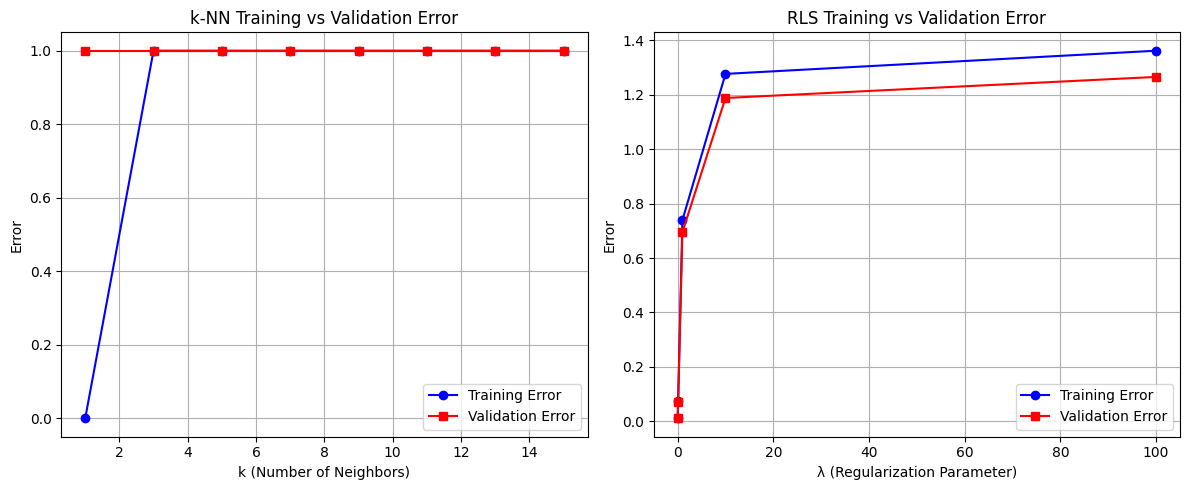

In [17]:
# datasets = ["dataset_2_train","dataset_3_train","dataset_5_train"]
datasets = ["dataset_2_train"]
KF = 5  
hyperparam_list = [1, 3, 5, 7, 9, 11, 13, 15]
regpar_list = [0.01, 0.1, 1, 10, 100]

result = []

for dataset in datasets:
    X, Y = load_dataset(dataset)
    plot_errors(X, Y, KF, regpar_list, hyperparam_list)
    
for res in result:
    print(res)
    
# print("Results:",result)

# for idx, dataset in enumerate(result):
#     print("Results for dataset: ", dataset)

#     compute_and_plot_metrics(X, Y, dataset, KF)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time

def train_best_models(Xtr, Ytr, KF, regpar_list, hyperparam_list):
    """
    Runs QFoldCV, selects the best k for k-NN and best λ for RLS, trains the models, 
    computes training time and training errors, and plots the results.

    Parameters:
    -----------
    Xtr : np.array
        Training dataset features.
    Ytr : np.array
        Training dataset labels.
    KF : int
        Number of folds for cross-validation.
    regpar_list : list
        List of regularization parameters (λ) for RLS.
    hyperparam_list : list
        List of k-values for k-NN.

    Returns:
    --------
    A dictionary with:
    - Best k, λ
    - Training time for k-NN & RLS
    - Final training errors for best parameters
    """

    # Run cross-validation
    results = QFoldCV(Xtr, Ytr, KF, regpar_list, hyperparam_list)

    # Extract k-NN results
    knn_k_values = hyperparam_list
    knn_tr_err = results['knn_tr_err_mean']
    knn_val_err = results['knn_val_err_mean']
    best_k = results['best_k']

    # Extract RLS results
    rls_lambda_values = regpar_list
    rls_tr_err = results['rls_tr_mean']
    rls_val_err = results['rls_val_mean']
    best_lambda = results['best_lam']

    # Train k-NN with best k
    start_time_knn = time.time()
    knn_train_pred = kNNClassify(Xtr, Ytr, best_k,Xtr)  
    knn_training_time = time.time() - start_time_knn
    knn_train_error = calcErrorKNN(knn_train_pred, Ytr)

    # Train RLS with best λ
    start_time_rls = time.time()
    rls_weights = regularizedLSTrain(Xtr, Ytr, best_lambda)
    rls_training_time = time.time() - start_time_rls
    rls_train_pred = regularizedLSTest(rls_weights, Xtr)
    rls_train_error = calcErrorRLS(rls_train_pred, Ytr) 

    # Plot k-NN Training and Validation Errors
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(knn_k_values, knn_tr_err, marker='o', label="Training Error", color='blue')
    plt.plot(knn_k_values, knn_val_err, marker='s', label="Validation Error", color='red')
    plt.axvline(best_k, linestyle="--", color="black", label=f"Best k = {best_k}")
    plt.xlabel("k (Number of Neighbors)")
    plt.ylabel("Error")
    plt.title("k-NN Training vs Validation Error")
    plt.legend()
    plt.grid(True)

    # Plot RLS Training and Validation Errors
    plt.subplot(1, 2, 2)
    plt.plot(rls_lambda_values, rls_tr_err, marker='o', label="Training Error", color='blue')
    plt.plot(rls_lambda_values, rls_val_err, marker='s', label="Validation Error", color='red')
    plt.axvline(best_lambda, linestyle="--", color="black", label=f"Best λ = {best_lambda}")
    plt.xlabel("λ (Regularization Parameter)")
    plt.ylabel("Error")
    plt.title("RLS Training vs Validation Error")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'best_k': best_k,
        'best_lambda': best_lambda,
        'knn_training_time': knn_training_time,
        'rls_training_time': rls_training_time,
        'knn_train_error': knn_train_error,
        'rls_train_error': rls_train_error
    }


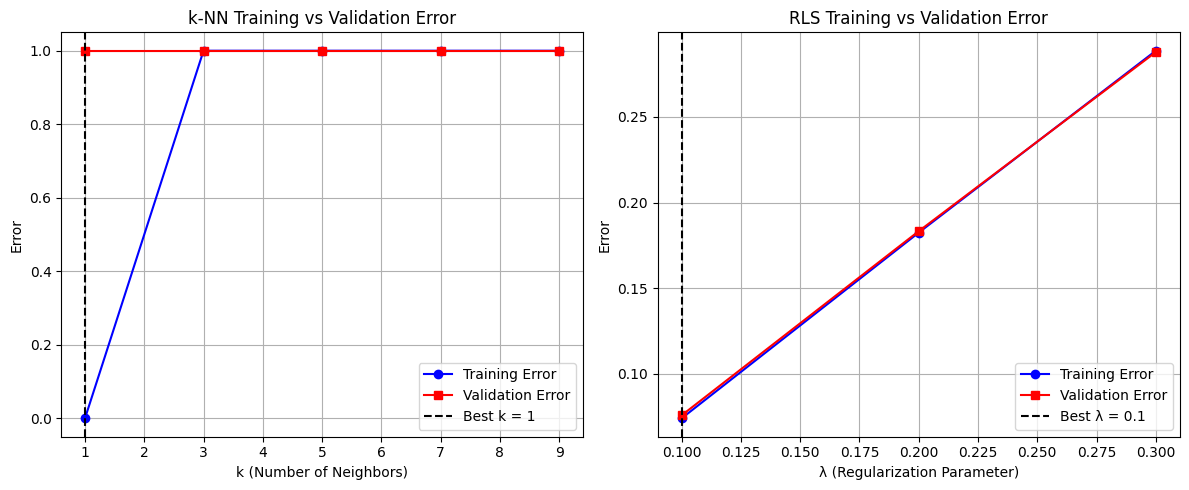

  Algorithm  Training Error  Test Error  Training Time (s)
0      k-NN        0.000000    0.000000           1.033499
1       RLS        0.074564    0.074564           0.000000


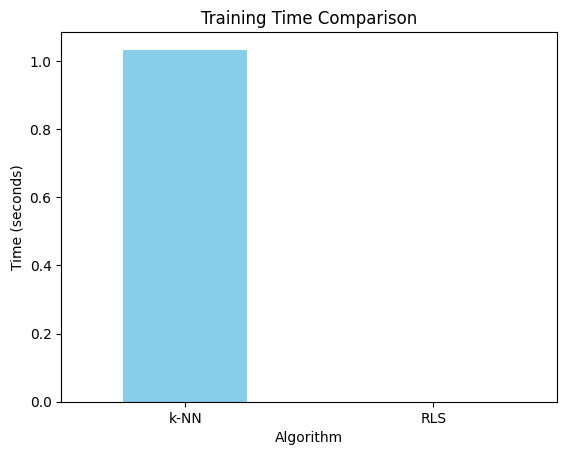

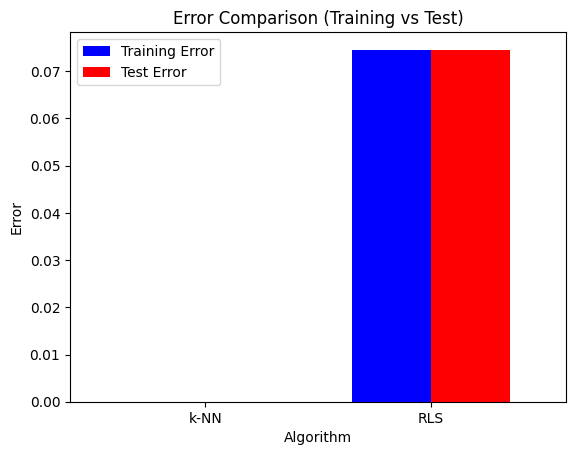

In [ ]:


# Step 1: Test k-NN and RLS models on the test dataset
def evaluate_models(Xtest, Ytest, knn_best_k, rls_best_lambda, Xtr, Ytr):
    # Test k-NN
    knn_test_pred = kNNClassify(Xtr, Ytr, knn_best_k, Xtest)
    knn_test_error = calcErrorKNN(knn_test_pred, Ytest)

    # Test RLS
    rls_weights = regularizedLSTrain(Xtr, Ytr, rls_best_lambda)  # Train RLS again with the best lambda
    rls_test_pred = regularizedLSTest(rls_weights, Xtest)
    rls_test_error = calcErrorRLS(rls_test_pred, Ytest)

    return knn_test_error, rls_test_error

# Step 2: Create a summary table of training times and errors
def create_summary_table(knn_train_error, rls_train_error, knn_test_error, rls_test_error,
                         knn_training_time, rls_training_time):
    data = {
        'Algorithm': ['k-NN', 'RLS'],
        'Training Error': [knn_train_error, rls_train_error],
        'Test Error': [knn_test_error, rls_test_error],
        'Training Time (s)': [knn_training_time, rls_training_time]
    }
    
    df = pd.DataFrame(data)
    return df

# Step 3: Visualize results with bar plots (Training Time and Errors)
def plot_results(df):
    # Bar plot for Training Time
    df.plot(x='Algorithm', y='Training Time (s)', kind='bar', color='skyblue', legend=False)
    plt.title("Training Time Comparison")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=0)
    plt.show()

    # Bar plot for Errors (Training and Test Error)
    df.plot(x='Algorithm', y=['Training Error', 'Test Error'], kind='bar', color=['blue', 'red'], width=0.7)
    plt.title("Error Comparison (Training vs Test)")
    plt.ylabel("Error")
    plt.xticks(rotation=0)
    plt.show()

# Example usage in the context of the full training procedure:
def train_and_evaluate(Xtr, Ytr, Xtest, Ytest, KF, regpar_list, hyperparam_list):
    # Train models and obtain best parameters and training times
    results = train_best_models(Xtr, Ytr, KF, regpar_list, hyperparam_list)
    
    # Extract the results
    best_k = results['best_k']
    best_lambda = results['best_lambda']
    knn_training_time = results['knn_training_time']
    rls_training_time = results['rls_training_time']
    knn_train_error = results['knn_train_error']
    rls_train_error = results['rls_train_error']

    # Step 1: Evaluate models on the test set
    knn_test_error, rls_test_error = evaluate_models(Xtest, Ytest, best_k, best_lambda, Xtr, Ytr)

    # Step 2: Create a summary table
    df_summary = create_summary_table(knn_train_error, rls_train_error, knn_test_error, rls_test_error,
                                      knn_training_time, rls_training_time)
    print(df_summary)

    # Step 3: Visualize results
    plot_results(df_summary)


# Example of how to use the function (you would replace Xtr, Ytr, Xtest, Ytest with your data)
# train_and_evaluate(Xtr, Ytr, Xtest, Ytest, KF=5, regpar_list=[0.1, 0.2, 0.3], hyperparam_list=[1, 3, 5, 7, 9])
# datasets = ["dataset_2_train","dataset_3_train","dataset_5_train"]
datasets = ["dataset_2_train"]
KF = 5  
hyperparam_list = [1, 3, 5, 7, 9, 11, 13, 15]
regpar_list = [0.01, 0.1, 1, 10, 100]


for dataset in datasets:
    X, Y = load_dataset(dataset)
    train_and_evaluate(Xtr=X, Ytr=Y, Xtest=X, Ytest=Y, KF, regpar_list, hyperparam_list)


    